**Arjun Krishnan - 6622982 - Natural Language Processing, Individual component - Notebook 3**
# Experiment 5 - Adapted from Yoon Kim's paper

Yoon Kim's paper was published in 2014, He built a CNN for sentence classification using word embeddings that out performed other benchmark classification models back in 2014. ***source***: https://arxiv.org/abs/1408.5882

He builds a model that takes in sentences as 300D vector of words, giving us 2D representation of each vector. He uses three approches that is random embeddings, static and non static word2vec, however I have only implemented static and non-static word2vec embeddings as the input to the model for due to time constrains. 

We adapt this model to see if performs well on our data, but by using  pre-trained 300D Word2Vec embeddings. we use 30 Epochs instead of 100 like Kim due to time and resource constraints and a batch size of 64 instead of 50 as it works best for our data after experimeting with several batch sizes. 

In [1]:
#ensuring that we are connected to GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
#making sure we are using all the available ram
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
#installing and importing the necessary libraries
!pip install unidecode
!pip install contractions
!pip install tensorflow-addons

import pandas as pd
import numpy as np
import matplotlib as plt
import re
import keras
import nltk
import sklearn
import gensim
import matplotlib.pyplot as plt
import os
import re
import tensorflow as tf
import seaborn as sns
import math

from nltk.tokenize import regexp_tokenize
from nltk.stem import WordNetLemmatizer

from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from keras.models import Model
from keras.layers import *
from keras.utils.np_utils import to_categorical
import tensorflow_addons as tfa
from tensorflow.python.keras.models import Model
from keras import regularizers
from tensorflow.python.keras.layers import Input, Activation, Conv2D, MaxPooling2D, BatchNormalization, UpSampling2D, Lambda, \
Conv2DTranspose, Permute, GaussianNoise, advanced_activations, Add, LeakyReLU, Dropout, ActivityRegularization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

     |████████████████████████████████| 245kB 5.3MB/s 
     |████████████████████████████████| 286kB 6.2MB/s 
     |████████████████████████████████| 327kB 8.6MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85392 sha256=28bf87add70448c409bb6aeaa69775bf495d77328f006a1948f143ee3cae8484
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick
     |████████████████████████████████| 706kB 6.5MB/s 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
os.chdir("./drive/MyDrive/NLPCW/")

In [6]:
os.listdir()

['Questions.csv',
 'Tags.csv',
 'GoogleNews-vectors-negative300.txt',
 'exp2_data.csv',
 'model2-EXP3.h5',
 'model2-EXP2.h5',
 'model5-NLPCW.h5',
 'model6-NLPCW.h5',
 'corpus_word2vec.txt',
 'preprocdata.csv',
 'preprocstats.csv',
 'model1-NLPCW.h5',
 'model2-NLPCW.h5',
 'model3-NLPCW.h5',
 'model4-NLPCW.h5']

In [7]:
#Reading pre processed data from notebook 1
df = pd.read_csv('preprocdata.csv')

In [8]:
df.head()

,Text,anova,bayesian,classification,clustering,correlation,distributions,hypothesis testing,logistic,machine learning,mathematical statistics,mixed model,multiple regression,neural networks,normal distribution,probability,r,regression,self study,statistical significance,time series
0,"['culture', 'statistic', 'v', 'machine_learnin...",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,"['bayesian_frequentist', 'reasoning', 'plain_e...",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"['meaning', 'p', 'value', 'value', 'statistica...",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"['example', 'teaching', 'correlation', 'mean',...",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"['large', 'difference', 'expected', 'standard'...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [9]:
#reading the df with class weights from notebook 1
df_stats = pd.read_csv('preprocstats.csv')
df_stats

,category,count,class_weight
0,anova,2505,31.946906
1,bayesian,2656,30.130648
2,classification,2881,27.777508
3,clustering,1952,40.997439
4,correlation,2871,27.874260
5,distributions,3501,22.858326
6,hypothesis testing,3869,20.684156
7,logistic,3316,24.133595
8,machine learning,6089,13.142881
9,mathematical statistics,1888,42.387182


In [10]:
sequence_length=300
num_filters = 300
#class weights to handle the imbalance in our data
class_weight = dict(df_stats.class_weight)

In [11]:
max_features = 200000 # this is the number of features we care about

tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(df['Text'].values)

# this takes our sentences and replaces each word with an integer
x = tokenizer.texts_to_sequences(df['Text'].values)

# we then pad the sequences so they're all the same length (sequence_length)
x = pad_sequences(x, sequence_length)
y = df.iloc[:, 1:]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 9000)

In [12]:
#Using Google's Word2vec model 

embeddings_index = {}
import os
f = open('GoogleNews-vectors-negative300.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors in Google word2vec model' % len(embeddings_index))

Found 3000000 word vectors in Google word2vec model


In [13]:
#printing the number of unique tokens in our data
word_index = tokenizer.word_index
print('Found %s unique tokens in our data' % len(word_index))

Found 79817 unique tokens in our data


In [14]:
#we run through all the words in our tokenizer and look for them in the w2v model.
#If they exist we add them to our embedding matrix, and if they don't then we assign a random vector
max_features = 2100626
embedding_dim = 300
num_words = min(max_features, len(word_index)) + 1
print(num_words)

# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

79818


Training our CNN5(experiment 5) model with Static Word2Vec Embeddings with the following hyperparameters:
1. Learning rate = 0.001
2. Epochs = 30
3. Batch size = 64

In [15]:
#building model 5- CNN5
num_classes=20
inputs = Input(shape=(sequence_length,), dtype='int32')

# note the `trainable=False`, later we will make this layer trainable
embedding_layer = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=False)(inputs)

reshape_2 = Reshape((sequence_length, embedding_dim, 1))(embedding_layer)

conv_0_2 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_2)
conv_1_2 = Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_2)
conv_2_2 = Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_2)

maxpool_0_2 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_2)
maxpool_1_2 = MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1_2)
maxpool_2_2 = MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2_2)


concatenated_tensor_2 = Concatenate(axis=1)([maxpool_0_2, maxpool_1_2,maxpool_2_2])
flatten_2 = Flatten()(concatenated_tensor_2)

dropout_2 = Dropout(0.5)(flatten_2)
output = Dense(units=20, activation='sigmoid')(dropout_2)

callbacks = [
    ReduceLROnPlateau(), 
    EarlyStopping(patience=4), 
    ModelCheckpoint(filepath='model5-NLPCW.h5', save_best_only=True)
]

model5 = Model(inputs=inputs, outputs=output)
model5.compile(optimizer= keras.optimizers.Nadam(learning_rate = 0.001),
              loss='binary_crossentropy', 
              metrics=[tfa.metrics.F1Score(num_classes=num_classes, average = 'micro', name = 'micro-f1'),
                       tfa.metrics.F1Score(num_classes=num_classes, average = 'macro', name = 'macro-f1'),
                       keras.metrics.BinaryAccuracy(name='binary-accuracy'),
                       keras.metrics.CategoricalAccuracy(name = 'categorical-accuracy')])

print(model5.summary())

history5 = model5.fit(x_train, y_train, 
                       epochs=30, 
                       class_weight = class_weight, 
                       callbacks = callbacks,
                       batch_size=64, 
                       verbose=1, 
                       validation_split=0.1)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 300)     23945400    input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 300, 300, 1)  0           embedding[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 298, 1, 300)  270300      reshape[0][0]                    
______________________________________________________________________________________________

In [25]:
CNN5 = keras.models.load_model('model5-NLPCW.h5') 

In [17]:
metrics = CNN5.evaluate(x_test, y_test)
print("The metrics for CNN model 5 on testing data:")
print("{}: {}".format(model5.metrics_names[0], metrics[0]))
print("{}: {}".format(model5.metrics_names[1], metrics[1]))
print("{}: {}".format(model5.metrics_names[2], metrics[2]))
print("{}: {}".format(model5.metrics_names[3], metrics[3]))
print("{}: {}".format(model5.metrics_names[4], metrics[4]))

353/353 [==============================] - 4s 9ms/step - loss: 1.2489 - micro-f1: 0.4669 - macro-f1: 0.3907 - binary-accuracy: 0.9312 - categorical-accuracy: 0.4342
The metrics for CNN model 5 on testing data:
loss: 1.2489336729049683
micro-f1: 0.4669445753097534
macro-f1: 0.39065566658973694
binary-accuracy: 0.9311761856079102
categorical-accuracy: 0.4341813623905182


In [18]:
#printing the Hamming loss for model 5
print('Hamming loss for CNN5: {0}'.format(sklearn.metrics.hamming_loss(y_test,  model5.predict(x_test).round(), sample_weight=None)))

Hamming loss for CNN5: 0.06830954702597287


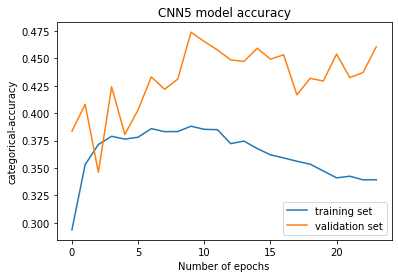

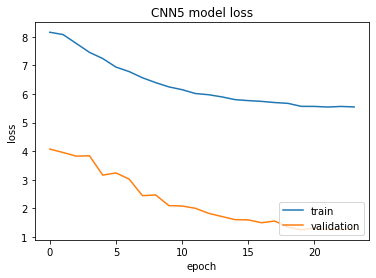

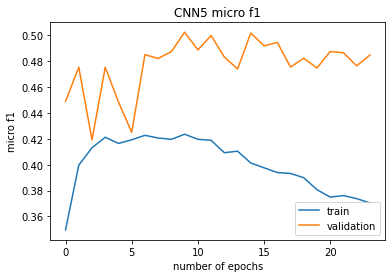

In [19]:
#plotting accuracy, loss and F1 score
plt.plot(history5.history['categorical-accuracy'])
plt.plot(history5.history['val_categorical-accuracy'])
plt.title('CNN5 model accuracy')
plt.ylabel('categorical-accuracy')
plt.xlabel('Number of epochs')
plt.legend(['training set', 'validation set'], loc='lower right')
plt.show()

plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('CNN5 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(history5.history['micro-f1'])
plt.plot(history5.history['val_micro-f1'])
plt.title('CNN5 micro f1')
plt.ylabel('micro f1')
plt.xlabel('number of epochs')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [20]:
confusion_matrix5 = sklearn.metrics.multilabel_confusion_matrix(y_test, model5.predict(x_test).round(), sample_weight=None)

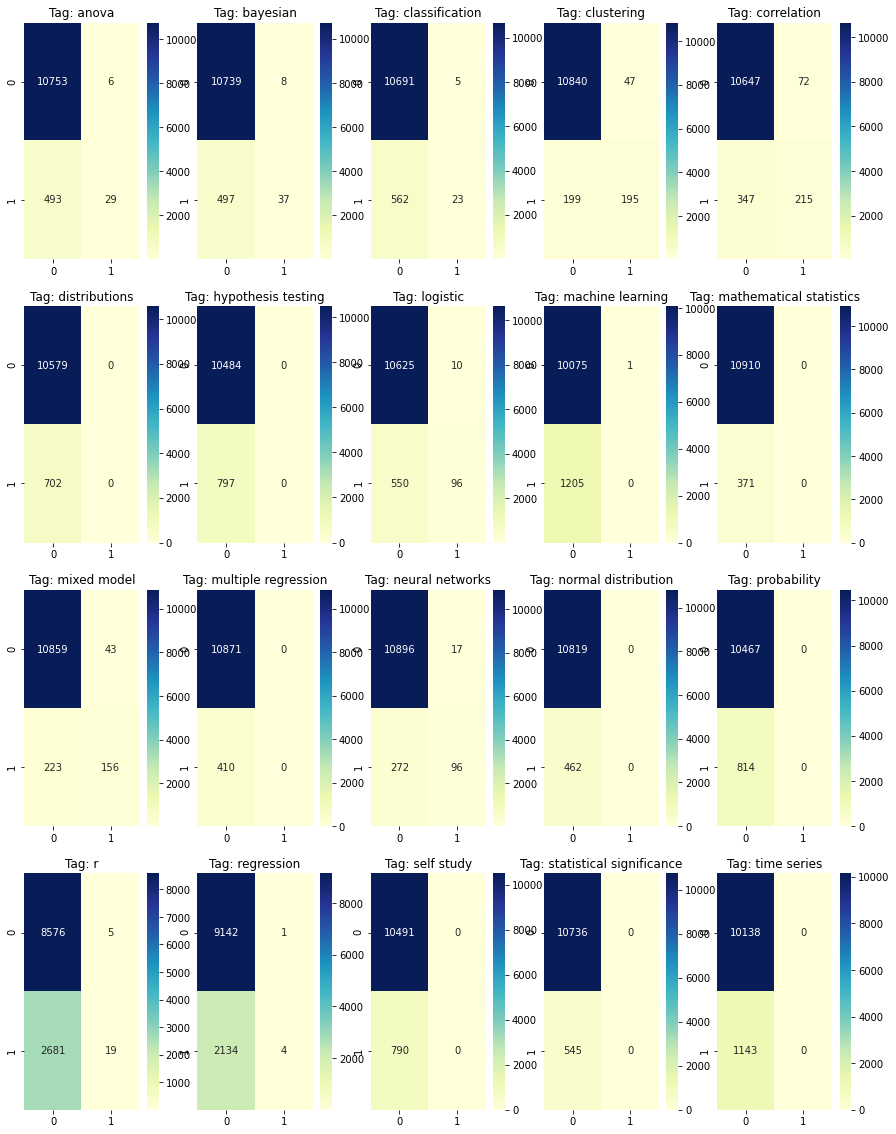

In [21]:
#plotting the confusion matrix for each labels
labelnames = df_stats['category']
labelnames = list(labelnames)

fig = plt.figure(figsize = (15,20))
cols=5
rows = math.ceil(len(labelnames)/cols)

for i, col in enumerate(labelnames):
  ax = fig.add_subplot(rows,cols, i +1)
  sns.heatmap(confusion_matrix5[i], annot = True, fmt = 'd', cmap = 'YlGnBu')
  ax.set(title = 'Tag: {0}'.format(col))

plt.show()

**Model comparison:**
 CNN5 adapted from Yoon Kim's paper is the worst performing model so far of all of our experiments. It is evident that the model struggles in predcting the negative(class 1) label of each binary output for the labels as seen from the confusion marices. The model has significantly higher losses and lower acuuracy and f1 scores when compared to others. Although the results expected maynot be as good as Kim achieved, the model still did good considering the type of data we are dealing with.

|Model |Hamming Loss|micro-F1|macro-F1 |Binary Accuracy|Categorical Accuracy  |
|------|------------|--------|---------|---------------|----------------------|
|CNN 1 | 0.0553     | 0.5236 |  0.5106 |    0.9446     |       0.5132         |
|CNN 2 | 0.0528     | 0.5852 |  0.5760 |    0.9519     |       0.5815         |
|CNN 3 | 0.0535     | 0.5585 |  0.5549 |    0.9478     |       0.5591         |
|CNN 4 | 0.0564     | 0.5414 |  0.5445 |    0.9466     |       0.5438         |
|CNN 5 | 0.0683     | 0.4669 |  0.3906 |    0.9311     |       0.4341         |



# Experiment 6 - Non static Word2Vec

Let us continue with our experimentation with trainable parameters, as Yoon Kim acheived signifant improvement in performance when setting the embeddings to be trainable.

Model6 with trainable parameters and similar hyperparameters. 

In [22]:
inputs2 = Input(shape=(sequence_length,), dtype='int32')

embedding_layer = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=True)(inputs2)

reshape_2 = Reshape((sequence_length, embedding_dim, 1))(embedding_layer)


conv_0_2 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_2)
conv_1_2 = Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_2)
conv_2_2 = Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_2)


maxpool_0_2 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_2)
maxpool_1_2 = MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1_2)
maxpool_2_2 = MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2_2)


concatenated_tensor_2 = Concatenate(axis=1)([maxpool_0_2, maxpool_1_2, maxpool_2_2])
flatten_2 = Flatten()(concatenated_tensor_2)

dropout_2 = Dropout(0.5)(flatten_2)
output = Dense(units=20, activation='sigmoid')(dropout_2)

callbacks = [
    ReduceLROnPlateau(), 
    EarlyStopping(patience=4), 
    ModelCheckpoint(filepath='model6-NLPCW.h5', save_best_only=True)
]

model6 = Model(inputs = inputs2, outputs=output)

model6.compile(optimizer= keras.optimizers.Nadam(learning_rate = 0.001),
              loss='binary_crossentropy', 
              metrics=[tfa.metrics.F1Score(num_classes=num_classes, average = 'micro', name = 'micro-f1'),
                       tfa.metrics.F1Score(num_classes=num_classes, average = 'macro', name = 'macro-f1'),
                       keras.metrics.BinaryAccuracy(name='binary-accuracy'),
                       keras.metrics.CategoricalAccuracy(name = 'categorical-accuracy')])

print(model6.summary())

 
history6 = model6.fit(x_train, y_train, 
                       epochs=30, 
                       class_weight = class_weight, 
                       callbacks = callbacks,
                       batch_size=64, 
                       verbose=1, 
                       validation_split=0.1)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 300)     23945400    input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 300, 300, 1)  0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 298, 1, 300)  270300      reshape_1[0][0]                  
____________________________________________________________________________________________

In [23]:
CNN6 = keras.models.load_model('model6-NLPCW.h5') 

In [24]:
metrics = CNN6.evaluate(x_test, y_test)
print("The metrics for CNN model 6 on testing data:")
print("{}: {}".format(model6.metrics_names[0], metrics[0]))
print("{}: {}".format(model6.metrics_names[1], metrics[1]))
print("{}: {}".format(model6.metrics_names[2], metrics[2]))
print("{}: {}".format(model6.metrics_names[3], metrics[3]))
print("{}: {}".format(model6.metrics_names[4], metrics[4]))

353/353 [==============================] - 3s 9ms/step - loss: 1.5040 - micro-f1: 0.5109 - macro-f1: 0.4991 - binary-accuracy: 0.9405 - categorical-accuracy: 0.5018
The metrics for CNN model 6 on testing data:
loss: 1.5040196180343628
micro-f1: 0.5108965635299683
macro-f1: 0.4991024434566498
binary-accuracy: 0.940546452999115
categorical-accuracy: 0.5018172264099121


In [26]:
#printing the Hamming loss for model 6
print('Hamming loss for CNN6: {0}'.format(sklearn.metrics.hamming_loss(y_test,  model6.predict(x_test).round(), sample_weight=None)))

Hamming loss for CNN6: 0.058447832638950446


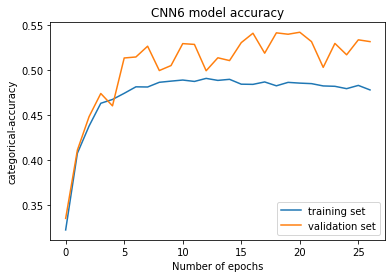

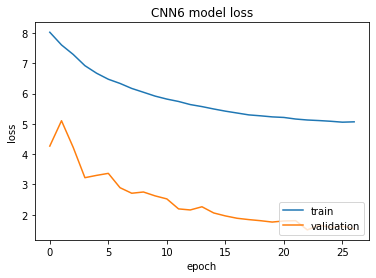

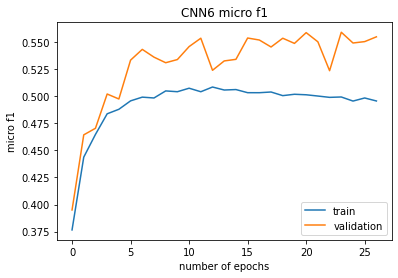

In [27]:
#plotting the loss, accuracy and micro f1 score on training and testing data
plt.plot(history6.history['categorical-accuracy'])
plt.plot(history6.history['val_categorical-accuracy'])
plt.title('CNN6 model accuracy')
plt.ylabel('categorical-accuracy')
plt.xlabel('Number of epochs')
plt.legend(['training set', 'validation set'], loc='lower right')
plt.show()

plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('CNN6 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(history6.history['micro-f1'])
plt.plot(history6.history['val_micro-f1'])
plt.title('CNN6 micro f1')
plt.ylabel('micro f1')
plt.xlabel('number of epochs')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()


In [28]:
confusion_matrix6 = sklearn.metrics.multilabel_confusion_matrix(y_test, model6.predict(x_test).round(), sample_weight=None)

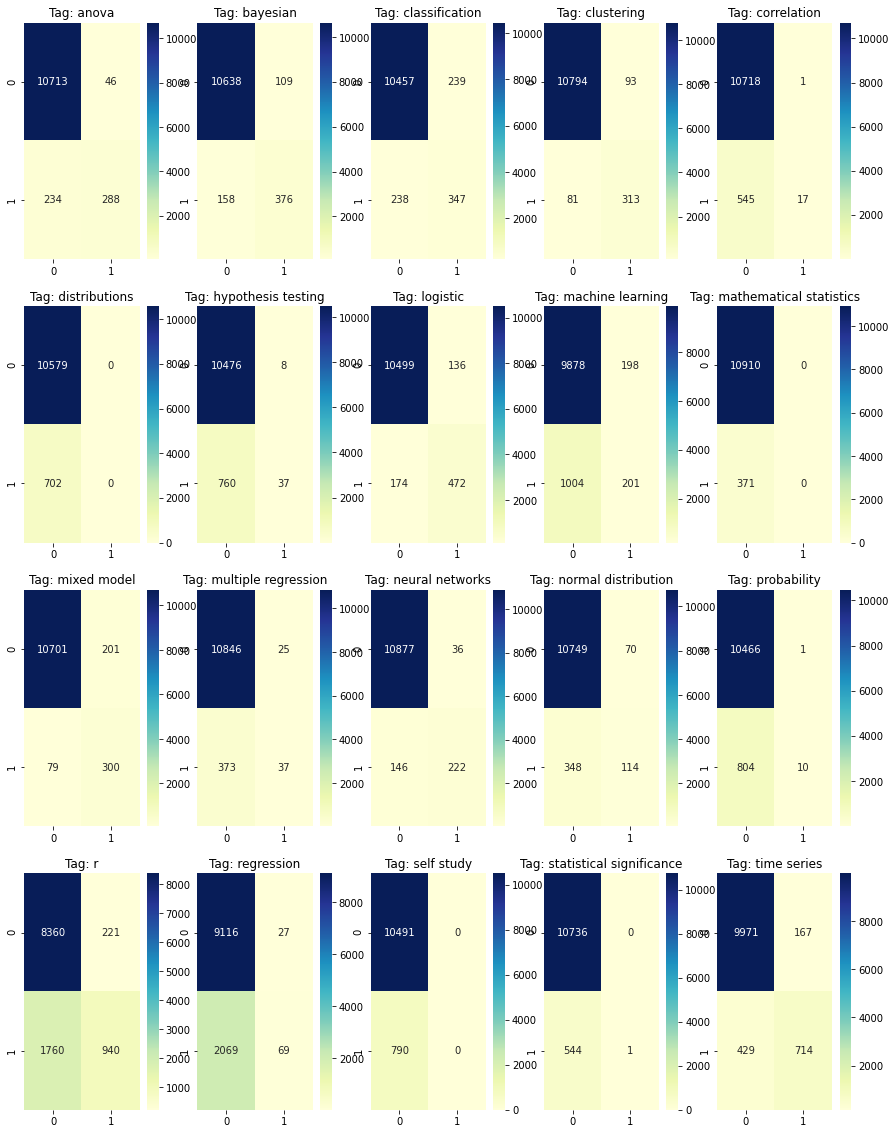

In [29]:
#plotting the confusion matrix for each labels
fig = plt.figure(figsize = (15,20))
cols=5
rows = math.ceil(len(labelnames)/cols)

for i, col in enumerate(labelnames):
  ax = fig.add_subplot(rows,cols, i +1)
  sns.heatmap(confusion_matrix6[i], annot = True, fmt = 'd', cmap = 'YlGnBu')
  ax.set(title = 'Tag: {0}'.format(col))

plt.show()

**Model coparison:** CNN 6 with trainable parameters performs better than the CNN 5 model without trainable performance, similar to Yoon Kim's paper. It does a better job at predicting labels on both the classes (0 and 1) compared model 5, as seen from the confusion matrices. Altough this may not be as good as our previous models the results are still fairly good considering the problem at hand.

|Model |Hamming Loss|micro-F1|macro-F1 |Binary Accuracy|Categorical Accuracy  |
|------|------------|--------|---------|---------------|----------------------|
|CNN 5 | 0.0683     | 0.4669 |  0.3906 |    0.9311     |       0.4341         |
|CNN 6 | 0.0584     | 0.5108 |  0.4991 |    0.9405     |       0.5018         |



# Model Evaluation and Results:

|Model |Hamming Loss|micro-F1|macro-F1 |Binary Accuracy|Categorical Accuracy  |
|------|------------|--------|---------|---------------|----------------------|
|CNN 1 | 0.0553     | 0.5236 |  0.5106 |    0.9446     |       0.5132         |
|CNN 2 | 0.0528     | 0.5852 |  0.5760 |    0.9519     |       0.5815         |
|CNN 3 | 0.0535     | 0.5585 |  0.5549 |    0.9478     |       0.5591         |
|CNN 4 | 0.0564     | 0.5414 |  0.5445 |    0.9466     |       0.5438         |
|CNN 5 | 0.0683     | 0.4669 |  0.3906 |    0.9311     |       0.4341         |
|CNN 6 | 0.0584     | 0.5108 |  0.4991 |    0.9405     |       0.5018         |

Experiemnt 2 (CNN 2) is the most accurate and best performing model out of all the 6 experiments carried over to solve the multilable classification problem as seen from the table above. It has outperformed all the other experiemts with the following hyperparameters and metrics:
1. Random trainable embedding with number of dimensions = 50
2. Number of Epochs = 10
3. Batch size = 64
4. maximum sentence length = 200
5. Learning rate = 0.001

|Model |Hamming Loss|micro-F1|macro-F1 |Binary Accuracy|Categorical Accuracy  |
|------|------------|--------|---------|---------------|----------------------|
|CNN 2 | 0.0528     | 0.5852 |  0.5760 |    0.9519     |       0.5815         |

As seen from confusion matrix from notebook 1, Experiment 2 had done a good job in predicting all the labels accurately without missing any labels entirely which is a common problem when dealing with multilabel classification especially in an imbalanced data like we are dealing with.

Overall, The convolutional neural networks has solved the problem at hand and the aim of the project has been succesfully completed by the all the experiments, with experiment 2 performing the best.

It is interesting to note that simple 1D CNN with trainbale word embeddings of 50 dimensions has outperformed the 300 dimensional 2D CNN model for the data at hand.

All of the models did good in predicting the labels and has exceeded the expectations. It is to be noted that all the results have been obtained after retraining the model numerous times with different optimizers, activation functions, learning rates, Batch sizes and the number of epochs. 

Several challenges were faced along the way due to the nature of the data. It contained a lot of low level informaton and had to be throughly cleaned before it was ready to be used as the input to the models. The data was also highly imbalanced and had to be tackled by using class weights while training the Neural Networks. 

Although, I expected better results while using Word2Vec as it has consistenly helped in obtaining good results for others based on my research, it could be because of the nature of our data being hihgly specific(technical) and several words in our corpus could have been missing in the pre-trained word2vec model. Thus leading to the results we have obtained. 

I would've like to experiment with different set-ups by using TF-IDF, Glove embeddings,Trigrams, Stemming etc. It would've also been interesting to compare pretrained word2vec embeddings to word2vec embeddings trained from our corpus, but unfortunately the short timeline of the module did not allow me to do so. 

***References:***
1. Labs from the Natural Language Processing Module
2. http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/
3. https://gombru.github.io/2018/05/23/cross_entropy_loss/
4. https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/
5. https://www.aclweb.org/anthology/D14-1181/
6. https://www.kaggle.com/umbertogriffo/cnn-yoon-kim-s-model-and-google-s-word2vec-model
